# Set up and packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import geopandas as gpd
import re 
from matplotlib.lines import Line2D
from matplotlib import font_manager
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.preprocessing import LabelEncoder

forest = '#284e13ff'
font_spec = 'Courier New'
xticks_font = font_manager.FontProperties(family='Courier New')

# Load data

In [8]:
df = pd.read_csv("data/assets_for_deforestation.csv", sep = "\t")
df.head()


,latitude,longitude,uid_gem,sector,capacity_unit,asset_name,country,start_year_first,capacity_first,start_year,capacity,number_units,sector_main,sector_sub,sector_main_num,sector_num
0,-52.936100,-70.828800,L905180,wind power/onshore,mw,Vientos Patagonicos wind farm,Chile,2020.0,10.0,[2020.0],[10.0],1,wind power,onshore,10,37
1,-51.546015,-72.231256,L100003,coal plant/bituminous,mw,Río Turbio power station,Argentina,2022.0,120.0,[2022.0],[120.0],1,coal plant,bituminous,3,7
2,-47.299500,-66.993100,L905447,wind power/onshore,mw,Bicentenario wind farm,Argentina,2019.0,25.0,"[2019.0, 2019.0]","[101.0, 25.0]",2,wind power,onshore,10,37
3,-46.634300,-68.392500,L905494,wind power/onshore,mw,Los Hercules wind farm,Argentina,2021.0,97.0,[2021.0],[97.0],1,wind power,onshore,10,37
4,-46.592500,-67.648600,L905533,wind power/onshore,mw,Canadon Leon wind farm,Argentina,2021.0,122.0,[2021.0],[122.0],1,wind power,onshore,10,37


In [57]:
print(f"Assets: {df.uid_gem.nunique()}")
print(f"Sub-assets: {df.shape[0]}")

Assets: 23847
Sub-assets: 26517


# Map of the world 

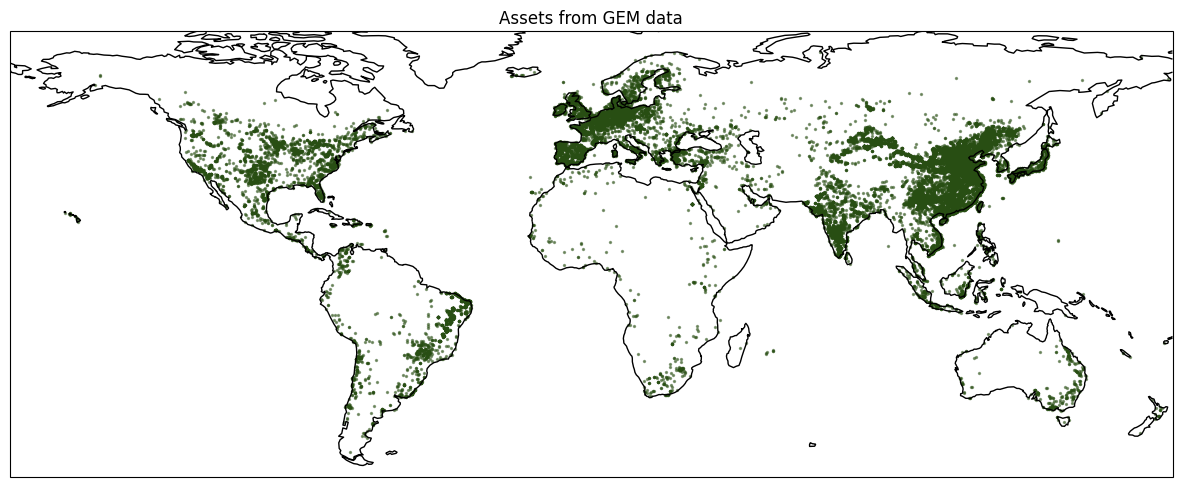

In [58]:
# Create a map of Brazil
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-70, -30, -40, 0])  # Define the extent of the map (lon_min, lon_max, lat_min, lat_max)

# Plot assets
ax.scatter(df['longitude'], df['latitude'],
           marker='o', 
           s=2, alpha = 0.5,
           transform=ccrs.PlateCarree(), color = forest)

# Add map features
ax.coastlines()

# Add country borders
# ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)



# Add title and labels
plt.title('Assets from GEM data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# save the plot
fig.savefig('graphs/map_assets_all.png', bbox_inches='tight')

# Restrict dataset

In [59]:
df = df[df.latitude.between(-30, -10) & df.longitude.between(-60, -40)]

In [60]:
print(f"Assets: {df.uid_gem.nunique()}")
print(f"Sub-assets: {df.shape[0]}")

Assets: 273
Sub-assets: 596


# Check missings

In [61]:
df.isnull().sum() # no missings! 

latitude            0
longitude           0
uid_gem             0
sector              0
capacity_unit       0
asset_name          0
country             0
start_year_first    0
capacity_first      0
start_year          0
capacity            0
number_units        0
dtype: int64

# Encode sector

In [62]:
# split sector 
df[['sector_main', 'sector_sub']] = df.sector.str.split("/", expand = True, n = 1)
df.isnull().sum()

latitude              0
longitude             0
uid_gem               0
sector                0
capacity_unit         0
asset_name            0
country               0
start_year_first      0
capacity_first        0
start_year            0
capacity              0
number_units          0
sector_main           0
sector_sub          160
dtype: int64

In [63]:
# check which sectors have missing subsectors
df[df.sector_sub.isnull()].groupby('sector').sector.count()

# check the share of missings within those sectors
df[df.sector_main == 'steel'].sector_main.count()
df[df.sector_main == 'bioenergy'].sector_main.count()
    # they are _always_ missing --> impute a category that sector_sub == sector_main

df['sector_sub'] = df['sector_sub'].fillna(df['sector_main'])

# check that there are no missings
assert df.isnull().sum().sum() == 0

In [64]:
# enumerate the sector labels

# initiate
label_encoder = LabelEncoder()

# transform
df['sector_main_num'] = label_encoder.fit_transform(df['sector_main'])
df['sector_num'] = label_encoder.fit_transform(df['sector'])

# glimpse at data
df.head()


,latitude,longitude,uid_gem,sector,capacity_unit,asset_name,country,start_year_first,capacity_first,start_year,capacity,number_units,sector_main,sector_sub,sector_main_num,sector_num
420,-29.9831,-50.3324,L905238,wind power/onshore,mw,Ventos Dos Índios wind farm,Brazil,2014.0,23.0,[2014.0],[23.0],1,wind power,onshore,6,8
421,-29.9776,-50.2831,L905237,wind power/onshore,mw,Ventos Do Sul wind farm,Brazil,2006.0,50.0,[2006.0],[50.0],1,wind power,onshore,6,8
422,-29.9679,-50.2826,L905237,wind power/onshore,mw,Ventos Do Sul wind farm,Brazil,2006.0,50.0,[2006.0],[50.0],1,wind power,onshore,6,8
424,-29.9595,-50.3155,L905233,wind power/onshore,mw,Ventos Da Lagoa wind farm,Brazil,2012.0,28.0,[2012.0],[28.0],1,wind power,onshore,6,8
426,-29.9583,-50.2833,L905237,wind power/onshore,mw,Ventos Do Sul wind farm,Brazil,2006.0,50.0,[2006.0],[50.0],1,wind power,onshore,6,8


In [65]:
print(f"Sectors: {df.sector_main.nunique()}")
print(f"Sub-sectors: {df.sector_sub.nunique()}")

Sectors: 7
Sub-sectors: 9


# Sumstats

In [66]:
df.describe()

,latitude,longitude,start_year_first,capacity_first,number_units,sector_main_num,sector_num
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,-16.368871,-45.791811,2016.090604,93.190772,1.073826,3.890940,5.315436
std,5.054192,4.327960,5.698460,745.925838,0.319537,2.091162,2.900796
min,-29.983100,-59.464200,2001.000000,2.700000,1.000000,0.000000,0.000000
25%,-20.486200,-49.605650,2012.000000,28.000000,1.000000,1.000000,1.000000
50%,-15.282850,-43.839600,2018.000000,34.000000,1.000000,4.000000,6.000000
75%,-11.816000,-42.575300,2021.000000,50.000000,1.000000,6.000000,8.000000
max,-10.004400,-40.074700,2023.000000,18000.000000,4.000000,6.000000,8.000000


In [67]:
df.head()

,latitude,longitude,uid_gem,sector,capacity_unit,asset_name,country,start_year_first,capacity_first,start_year,capacity,number_units,sector_main,sector_sub,sector_main_num,sector_num
420,-29.9831,-50.3324,L905238,wind power/onshore,mw,Ventos Dos Índios wind farm,Brazil,2014.0,23.0,[2014.0],[23.0],1,wind power,onshore,6,8
421,-29.9776,-50.2831,L905237,wind power/onshore,mw,Ventos Do Sul wind farm,Brazil,2006.0,50.0,[2006.0],[50.0],1,wind power,onshore,6,8
422,-29.9679,-50.2826,L905237,wind power/onshore,mw,Ventos Do Sul wind farm,Brazil,2006.0,50.0,[2006.0],[50.0],1,wind power,onshore,6,8
424,-29.9595,-50.3155,L905233,wind power/onshore,mw,Ventos Da Lagoa wind farm,Brazil,2012.0,28.0,[2012.0],[28.0],1,wind power,onshore,6,8
426,-29.9583,-50.2833,L905237,wind power/onshore,mw,Ventos Do Sul wind farm,Brazil,2006.0,50.0,[2006.0],[50.0],1,wind power,onshore,6,8


# Maps for presentation

## Map of Brazil


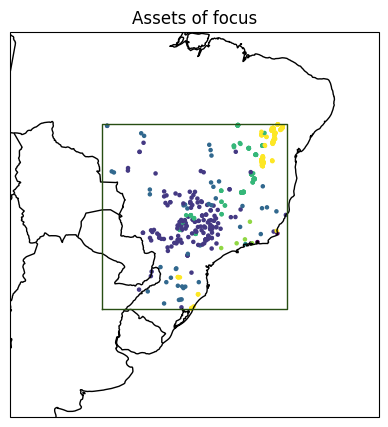

In [68]:
# Create a map of Brazil
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-70, -30, -40, 0])  # Define the extent of the map (lon_min, lon_max, lat_min, lat_max)

# Plot assets
ax.scatter(df['longitude'], df['latitude'], c=df['sector_main_num'], 
           marker='o', 
           s=5, 
           transform=ccrs.PlateCarree())

# Add map features
ax.coastlines()

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)

# Add a square highlighting the right area
ax.plot([-60, -40, -40, -60, -60], [-30, -30, -10, -10, -30],
         color=forest, linewidth=1, marker='',
         transform=ccrs.Geodetic(), #remove this line to get straight lines
         )

# Add title and labels
plt.title('Assets of focus')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# save the plot
fig.savefig('graphs/map_assets_of_interest.png', bbox_inches='tight')

# Summary stats on a graph

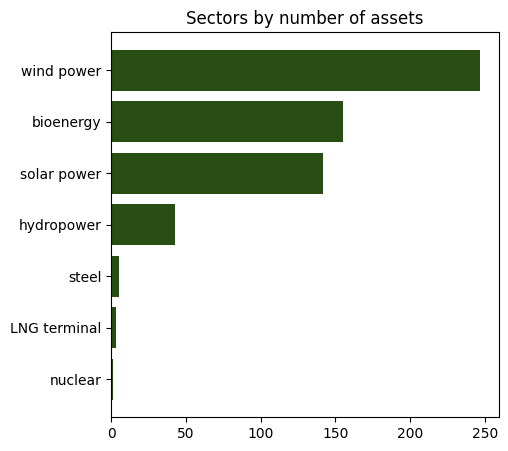

In [69]:

top_sectors = df.groupby('sector_main').uid_gem.count().reset_index().sort_values('uid_gem')
top_sectors

fig = plt.figure(figsize=(5, 5))

plt.barh(top_sectors.sector_main, top_sectors.uid_gem, color = forest)
plt.title('Sectors by number of assets')
plt.show()

fig.savefig('graphs/hbar_sectors.png', bbox_inches='tight')

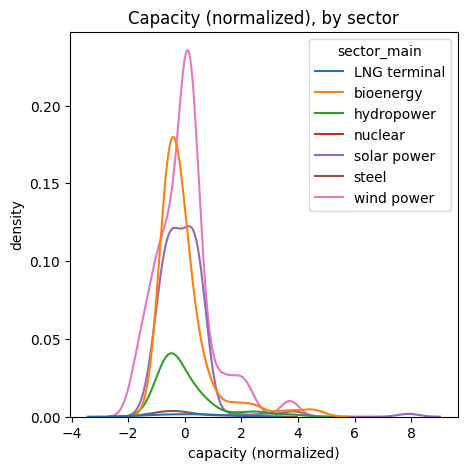

In [70]:
# normalize capacity within group

def normalize_group(sector_main):
    sector_main['capacity_norm'] = (sector_main['capacity_first'] - sector_main['capacity_first'].mean()) / sector_main['capacity_first'].std()
    return sector_main

# Apply the function to each group
normalized_data = df.groupby('sector_main').apply(normalize_group).reset_index(drop = True)

fig = plt.figure(figsize=(5, 5))
sns.kdeplot(data = normalized_data, x = 'capacity_norm', hue = 'sector_main')
plt.xlabel('capacity (normalized)')
plt.ylabel('density')
plt.title('Capacity (normalized), by sector')


fig.savefig('graphs/kde_sectors.png', bbox_inches='tight')